<a href="https://colab.research.google.com/github/rlawogjs96/deeplearning_paper_reviews/blob/main/Neural_Machine_Translation_by_Jointly_Learning_to_Align_and_Translate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Machine Translation by Jointly Learning to Align and Translate

* RNN based Seq2Seq Model에는 두 가지 단점이 존재: Information Loss 와 Vanishing Gradient가 있다. 따라서 Attention Mechanism을 활용하여 Decoder가 매번 Target Sequence를 파악할때마다 attention을 주는 기법을 활용한다. 해당 논문에서는 Seq2Seq 구조에서 Attention Mechanism과 Bi-Directional RNN을 소개한다. 

* Seq2Seq 구조는 Encoder와 Decoder의 구성으로 되어있다. Encoder의 역할은 입력 sentence를 받아 fixed size vector로 반환한다. 하지만 고정된 길이로 인한 문제점을 보완하기 위해 Decoder에서 source sentence에 특정 부분에 'attention'을 준다. 

* Bi-Directional RNN은 input sequence를 순서대로 읽는 RNN 하나 (forward hidden states의 순서 계산), 그리고 역방향으로 sequence를 읽는 RNN 하나가 있다 (backward hidden states 계산). 이 둘의 출력 hidden states를 concat으로 연결함으로서 hidden state는 단어 주변의 단어들에 집중할 수 있다.

**What is Attention Mechanism?**

Seq2Seq model: 
*   **Encoder:** The encoder processes each token in the input-sentence. Vector of fixed length is created that holds information about input sentence. (context vector) The encoder pases this vector onto the decoder.
*   **Decoder:** The decoder reads the context vector and predicts target sequence token by token. 

However, this RNN based Seq2Seq model has two critical flaws: 
1.   **Information Loss** occuring due to cramming all information in one vector of fixed length. 
2.   **Vanishing Gradient** issue that is ubiquitous in RNN.

The idea of attention mechanism is to 'pay attention' to the input sentence in the encoder every time step the decoder predicts target sequence. Each time the model predicts an output word, it only uses parts of the input where the most relevant information is concentrated instead of the entire sequence. Only pays attention to some input words. 

Attention is an interface connecting the encoder and decoder that provides the decoder with the information from every encoder hidden state. With this framework, the model is able to selectively focus on valuable parts of the input sentence and hence, learn the assocation between them. This helps the model to cope efficiently with long input sentences.





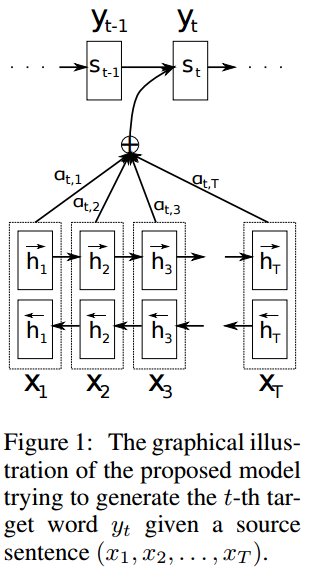

**Bi-Directional RNN**

Bi-Directional RNN is also used along with the attention mechanism. First RNN reads input sentence sequentially and calculates order of the forward hidden states. Second RNN reads input sequence non-sequentially(backwards) and calculates backward hidden states. The hidden state of these two outputs are connected via concat. The concated hidden state can now focus on words surroudning word 'x'.


## Abstract

  Neural machine translation is a recently proposed approach to machine translation. Unlike the traditional statistical machine translation, the neural machine translation aims at building a single neural network that can be jointly tuned to maximize the translation performance. The models proposed recently for neural machine translation often belong to a family of encoder-decoders and encode a source sentence into a fixed-length vector from which a decoder generates a translation. In this paper, we conjecture that the use of a fixed-length vector is a bottleneck in improving the performance of this basic encoder-decoder architecture, and propose to extend this by allowing a model to automatically (soft-)search for parts of a source sentence that are relevant to predicting a target word, without having to form these parts as a hard segment explicitly. With this new approach, we achieve a translation performance comparable to the existing state-of-the-art phrase-based system on the task of English-to-French translation. Furthermore, qualitative analysis reveals that the (soft-)alignments found by the model agree well with our intuition.

### 1. Prepare Data

In [ ]:
#1.1 Import token models (spacy) 
!python -m spacy download en 
!python -m spacy download de

⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 4.6 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ As of spaCy v3.0, shortcuts like 'de' are deprecated. Please use the
full pipeline package name 'de_core_news_sm' instead.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 14.6 MB 5.0 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')


In [ ]:
!pip install torchtext==0.11.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchtext.legacy.datasets import Multi30k
from torchtext.legacy.data import Field, BucketIterator

import spacy
import numpy as np

import random
import math
import time

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

spacy_en = spacy.load('en_core_web_sm')
spacy_de = spacy.load('de_core_news_sm')
# English, German Token function 
def tokenize_de(text): 
  return [token.text for token in spacy_de.tokenizer(text)][::-1]

def tokenize_en(text): 
  return [token.text for token in spacy_en.tokenizer(text)]

SRC = Field(tokenize = tokenize_de, 
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True)

TRG = Field(tokenize = tokenize_en,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True)

In [ ]:
from torchtext.legacy.datasets import Multi30k

train_data, valid_data, test_data = Multi30k.splits(exts=('.de', '.en'), fields = (SRC, TRG))

In [ ]:
# Create dictionary
SRC.build_vocab(train_data, min_freq=2)
TRG.build_vocab(train_data, min_freq=2)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), batch_size = batch_size, device = device)

**Encoder** 

Encoder uses Bi-Directional RNN. 
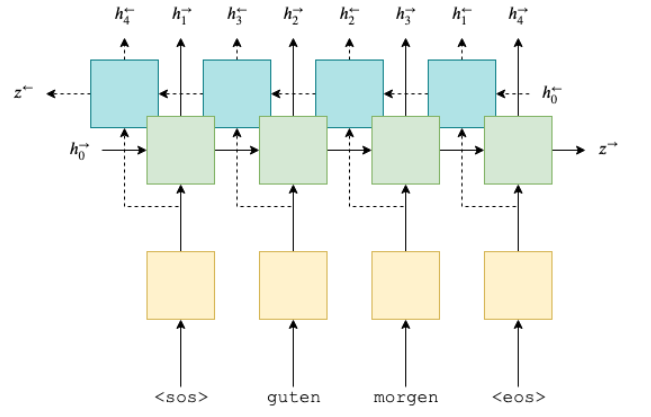

We have two RNNs in each layer. A forward RNN going over the embedded sentence from left to right, and a backward RNN going over the embedded sentence from right to left. 


In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [src len, batch size]
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
        outputs, hidden = self.rnn(embedded)
                
        #outputs = [src len, batch size, hid dim * num directions]
        #hidden = [n layers * num directions, batch size, hid dim]
        
        #hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        #outputs are always from the last layer
        
        #hidden [-2, :, : ] is the last of the forwards RNN 
        #hidden [-1, :, : ] is the last of the backwards RNN
        
        #initial decoder hidden is final hidden state of the forwards and backwards 
        #  encoder RNNs fed through a linear layer
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        
        #outputs = [src len, batch size, enc hid dim * 2]
        #hidden = [batch size, dec hid dim]
        
        return outputs, hidden

**Attention** 

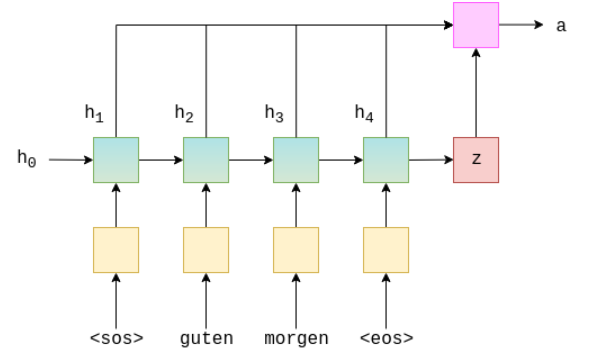

The attention layer takes in previous hidden state of the decoder and all of the stacked forward and backward hidden states from the encoder in order to calculate the attention vector. The length of the attention vector has components 0 and 1. (same with source sentence) 

Energy is calculated as $$E_t = \tanh(\text{attn}(s_{t-1}, H))$$


We currently have a **[dec hid dim, src len]** tensor for each example in the batch. We want this to be **[src len]** for each example in the batch as the attention should be over the length of the source sentence. This is achieved by multiplying the `energy` by a **[1, dec hid dim]** tensor, $v$.

$$\hat{a}_t = v E_t$$

We ensure the attention vector fits the constraints of having all elements between 0 and 1 and the vector summing to 1 by passing it through a $\text{softmax}$ layer.

$$a_t = \text{softmax}(\hat{a_t})$$

In [ ]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs):
        
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        #repeat decoder hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #hidden = [batch size, src len, dec hid dim]
        
        #energy = [batch size, src len, dec hid dim]
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
  
        #attention= [batch size, src len]
        attention = self.v(energy).squeeze(2)
    
        return F.softmax(attention, dim=1)

**Decoder** 

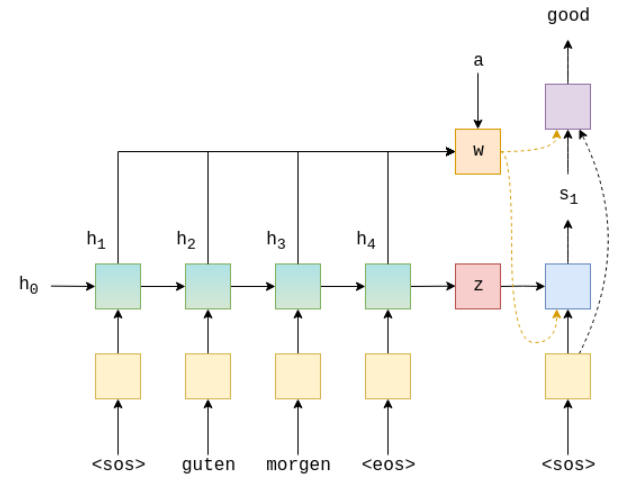

The decoder contains the attention layer, `attention`, which takes the previous hidden state, $s_{t-1}$, all of the encoder hidden states, $H$, and returns the attention vector, $a_t$.

We then use this attention vector to create a weighted source vector, $w_t$, denoted by `weighted`, which is a weighted sum of the encoder hidden states, $H$, using $a_t$ as the weights.

$$w_t = a_t H$$

The embedded input word, $d(y_t)$, the weighted source vector, $w_t$, and the previous decoder hidden state, $s_{t-1}$, are then all passed into the decoder RNN, with $d(y_t)$ and $w_t$ being concatenated together.

$$s_t = \text{DecoderGRU}(d(y_t), w_t, s_{t-1})$$

We then pass $d(y_t)$, $w_t$ and $s_t$ through the linear layer, $f$, to make a prediction of the next word in the target sentence, $\hat{y}_{t+1}$. This is done by concatenating them all together.

$$\hat{y}_{t+1} = f(d(y_t), w_t, s_t)$$

The image below shows decoding the first word in an example translation.

![](assets/seq2seq10.png)

The green/teal blocks show the forward/backward encoder RNNs which output $H$, the red block shows the context vector, $z = h_T = \tanh(g(h^\rightarrow_T,h^\leftarrow_T)) = \tanh(g(z^\rightarrow, z^\leftarrow)) = s_0$, the blue block shows the decoder RNN which outputs $s_t$, the purple block shows the linear layer, $f$, which outputs $\hat{y}_{t+1}$ and the orange block shows the calculation of the weighted sum over $H$ by $a_t$ and outputs $w_t$. Not shown is the calculation of $a_t$.

In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)       
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs):
             
        #input = [batch size]
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        #input = [1, batch size]
        input = input.unsqueeze(0)
        
        #embedded = [1, batch size, emb dim]
        embedded = self.dropout(self.embedding(input))
        
        a = self.attention(hidden, encoder_outputs)
                
        #a = [batch size, src len]
        a = self.attention(hidden, encoder_outputs)
        
        #a = [batch size, 1, src len]
        a = a.unsqueeze(1)
      
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
   
        #weighted = [batch size, 1, enc hid dim * 2]
        weighted = torch.bmm(a, encoder_outputs)
 
        #weighted = [1, batch size, enc hid dim * 2]
        weighted = weighted.permute(1, 0, 2)
        
        #rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        
        #output = [seq len, batch size, dec hid dim * n directions]  
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        
        #hidden = [n layers * n directions, batch size, dec hid dim]
        
        #seq len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        #this also means that output == hidden
        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden.squeeze(0)

**Seq2Seq**

This is the first model where we don't have to have the encoder RNN and decoder RNN have the same hidden dimensions, however the encoder has to be bidirectional. This requirement can be removed by changing all occurences of `enc_dim * 2` to `enc_dim * 2 if encoder_is_bidirectional else enc_dim`. 

This seq2seq encapsulator is similar to the last two. The only difference is that the `encoder` returns both the final hidden state (which is the final hidden state from both the forward and backward encoder RNNs passed through a linear layer) to be used as the initial hidden state for the decoder, as well as every hidden state (which are the forward and backward hidden states stacked on top of each other). We also need to ensure that `hidden` and `encoder_outputs` are passed to the decoder. 

Briefly going over all of the steps:
- the `outputs` tensor is created to hold all predictions, $\hat{Y}$
- the source sequence, $X$, is fed into the encoder to receive $z$ and $H$
- the initial decoder hidden state is set to be the `context` vector, $s_0 = z = h_T$
- we use a batch of `<sos>` tokens as the first `input`, $y_1$
- we then decode within a loop:
  - inserting the input token $y_t$, previous hidden state, $s_{t-1}$, and all encoder outputs, $H$, into the decoder
  - receiving a prediction, $\hat{y}_{t+1}$, and a new hidden state, $s_t$
  - we then decide if we are going to teacher force or not, setting the next input as appropriate.

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
        
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src)
                
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden state and all encoder hidden states
            #receive output tensor (predictions) and new hidden state
            output, hidden = self.decoder(input, hidden, encoder_outputs)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1

        return outputs

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, device).to(device)

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7853, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(5893, 256)
    (rnn): GRU(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=5893, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

Calculate number of parameters.

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 20,518,405 trainable parameters


We create an optimizer and initialize the loss function. 

In [ ]:
optimizer = optim.Adam(model.parameters())

In [ ]:
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

We establish the training loop.

In [ ]:
def train(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0
  
    for i, batch in enumerate(iterator):
        src = batch.src
        trg = batch.trg
        optimizer.zero_grad()
        output = model(src, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

We create the evaluation loop.

In [ ]:
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg
            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]
            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]
            loss = criterion(output, trg)
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

We train our model saving the parameters that return the best validation loss.

In [ ]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    start_time = time.time()
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut3-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 1m 28s
	Train Loss: 5.060 | Train PPL: 157.652
	 Val. Loss: 4.963 |  Val. PPL: 143.019
Epoch: 02 | Time: 1m 30s
	Train Loss: 4.088 | Train PPL:  59.609
	 Val. Loss: 4.109 |  Val. PPL:  60.861
Epoch: 03 | Time: 1m 31s
	Train Loss: 3.311 | Train PPL:  27.401
	 Val. Loss: 3.618 |  Val. PPL:  37.245
Epoch: 04 | Time: 1m 30s
	Train Loss: 2.804 | Train PPL:  16.515
	 Val. Loss: 3.333 |  Val. PPL:  28.011
Epoch: 05 | Time: 1m 31s
	Train Loss: 2.443 | Train PPL:  11.510
	 Val. Loss: 3.187 |  Val. PPL:  24.226
Epoch: 06 | Time: 1m 30s
	Train Loss: 2.128 | Train PPL:   8.396
	 Val. Loss: 3.247 |  Val. PPL:  25.714
Epoch: 07 | Time: 1m 31s
	Train Loss: 1.913 | Train PPL:   6.773
	 Val. Loss: 3.199 |  Val. PPL:  24.512
Epoch: 08 | Time: 1m 31s
	Train Loss: 1.706 | Train PPL:   5.506
	 Val. Loss: 3.229 |  Val. PPL:  25.248
Epoch: 09 | Time: 1m 30s
	Train Loss: 1.559 | Train PPL:   4.753
	 Val. Loss: 3.314 |  Val. PPL:  27.488
Epoch: 10 | Time: 1m 30s
	Train Loss: 1.433 | Train PPL

In [ ]:
model.load_state_dict(torch.load('tut3-model.pt'))
test_loss = evaluate(model, test_iterator, criterion)
print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 3.177 | Test PPL:  23.979 |
